# Task
### Implement 3 clases for the active matter dataset:
- DataLoader
- Model
- Training class

References:
- https://arxiv.org/pdf/2412.00568
- https://github.com/hernanmorales-navarrete/EPIC_5/blob/main/Tutorials/tutorial_6/code/2_NoiseRemoval_Autoencoders.ipynb
- https://github.com/hernanmorales-navarrete/EPIC_5/blob/main/Tutorials/tutorial_6/code/3_ImageSegmentation_UNet.ipynb
- https://tutorial.rise-miccai.org/Beginner_tuto/Retina_classification_using_CNN_.html
- https://github.com/PolymathicAI/the_well
- https://polymathic-ai.org/the_well/tutorials/dataset/

In [1]:
# Check
import torch
import os

# Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from the_well.data import WellDataset
from einops import rearrange

# Model Conv Next
import torch
import torch.nn as nn
import torch.nn.functional as F

# Training
from tqdm import tqdm

def check_device():
    """
    Checks if a CUDA-capable GPU is available, prints device info,
    and runs a small matrix multiplication test to confirm GPU functionality.
    Also prints the number of available CPU workers.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("⚠️ No GPU found. Using CPU.")

    num_workers = os.cpu_count()
    print(f"🧠 Number of available CPU workers: {num_workers}")
    print(f"🖥️ Using device: {device}")

    # Simple test calculation
    try:
        a = torch.rand((1000, 1000), device=device)
        b = torch.rand((1000, 1000), device=device)
        c = torch.matmul(a, b)
        torch.cuda.synchronize() if device.type == 'cuda' else None
        print("✅ GPU test calculation completed successfully.")
    except Exception as e:
        print(f"❌ GPU test failed: {e}")

    return device

# Run the device check
device = check_device()

✅ GPU available: NVIDIA GeForce RTX 5060 Ti
🧠 Number of available CPU workers: 24
🖥️ Using device: cuda
✅ GPU test calculation completed successfully.


d:\Jhon\miniconda3\envs\DA_ML\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5060 Ti with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5060 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


# 1 DataSet Class

In [2]:
device = "cuda"
base_path = "./datasets"  # path/to/storage
stride = 1

In [5]:
# from the_well.utils.download import well_download
# well_download(base_path=base_path, dataset="active_matter", split="train")
# well_download(base_path=base_path, dataset="active_matter", split="valid")
# well_download(base_path=base_path, dataset="active_matter", split="test")

In [ ]:
class MyDataset(Dataset):
    def __init__(self, mysplit, arch = 'LSTM'):
        self.arch = arch
        self.raw = WellDataset(
            well_base_path=f"{base_path}/datasets",
            well_dataset_name="active_matter",
            well_split_name=mysplit,
            n_steps_input=4,
            n_steps_output=1,
            min_dt_stride=stride,
            use_normalization=True,
        )
    
    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx):
        D = self.raw[idx]
        x = D["input_fields"]
        y = D["output_fields"]
        if self.arch == 'CNext':
            # Move channels last → channels first
            x = x.permute(0, 3, 1, 2)   # (B,4,11,256,256)
            y = y.permute(0, 3, 1, 2)   # (B,1,11,256,256)
            # Flatten temporal dimension into channels
            x = x.reshape(4*11, 256, 256)  # (B,44,256,256)
            # Remove time dimension of target
            y = y.reshape(11, 256, 256)     # (B,11,256,256)
            
        
        return x, y

In [4]:
training_data = MyDataset('train', 'CNext')

In [5]:
a = training_data.raw

In [6]:
dataset = training_data.raw
print(type(dataset), len(dataset))
x = dataset[42]
print(type(x),x.keys())
print(x['input_fields'].shape)
print(x['output_fields'].shape)


FF = dataset.metadata.n_fields
field_names = [
    name for group in dataset.metadata.field_names.values() for name in group
]
print(field_names)

<class 'the_well.data.datasets.WellDataset'> 13475
<class 'dict'> dict_keys(['input_fields', 'output_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid', 'output_time_grid'])
torch.Size([4, 256, 256, 11])
torch.Size([1, 256, 256, 11])
['concentration', 'velocity_x', 'velocity_y', 'D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']


### Data point visualizer

In [7]:
def plot_sequence(datapoint):
    x = datapoint["input_fields"]
    y = datapoint["output_fields"]
    x = rearrange(x, "T Lx Ly F -> F T Lx Ly")
    y = rearrange(y, "T Lx Ly F -> F T Lx Ly")

    len_x = x.shape[1]
    len_y = y.shape[1]

    fig, axs = plt.subplots(FF, len_x + len_y, figsize=((len_x + len_y) * 1.3, FF * 1.2))

    for field in range(FF):
        vmin = np.nanmin(x[field])
        vmax = np.nanmax(x[field])

        axs[field, 0].set_ylabel(f"{field_names[field]}")

        for t in range(len_x):
            axs[field, t].imshow(
                x[field, t], cmap="viridis", interpolation="none", vmin=vmin, vmax=vmax
            )
            axs[field, t].set_xticks([])
            axs[field, t].set_yticks([])
            axs[0, t].set_title(f"$t_{t}$​")

        for t in range(len_y):
            axs[field, len_x + t].imshow(
                y[field, t], cmap="viridis", interpolation="none", vmin=vmin, vmax=vmax
            )
            axs[field, len_x + t].set_xticks([])
            axs[field, len_x + t].set_yticks([])
            axs[0, len_x + t].set_title(f"$tp_{t}$​")


    plt.tight_layout()
    plt.show()
    plt.close()

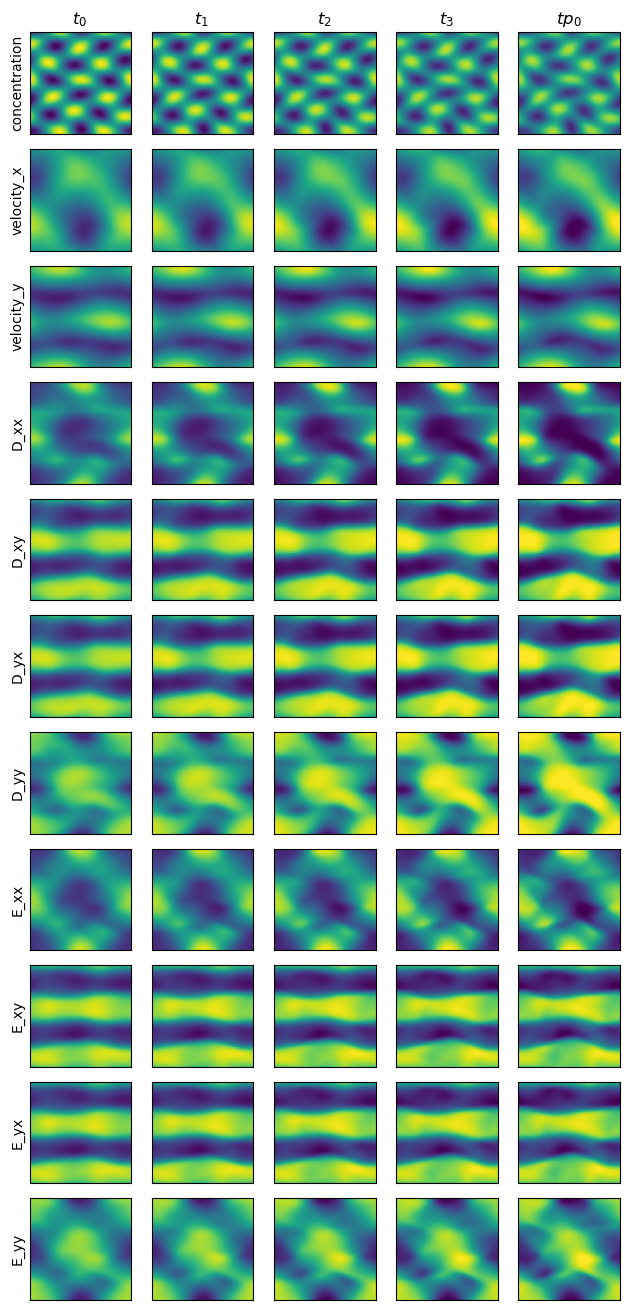

In [8]:
plot_sequence(dataset[42])

# 2 Model

CNextU-net
- Spatial filter size - 7
- Initial dimension - 42
- Blocks per stage - 2
- Up/Down blocks - 4
- Bottleneck blocks - 1

In [13]:
#   ConvNeXt-like block 
class CNextBlock(nn.Module):
    def __init__(self, dim, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2

        self.dwconv = nn.Conv2d(dim, dim, kernel_size, padding=padding, groups=dim)  # depthwise
        self.norm = nn.GroupNorm(1, dim)  # LayerNorm-like
        self.pwconv1 = nn.Conv2d(dim, 4 * dim, kernel_size=1)
        self.pwconv2 = nn.Conv2d(4 * dim, dim, kernel_size=1)
        self.act = nn.GELU()

    def forward(self, x):
        residual = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        return x + residual



#   Basic Down Block
class DownStage(nn.Module):
    def __init__(self, in_dim, out_dim, num_blocks, kernel_size):
        super().__init__()
        self.blocks = nn.Sequential(*[
            CNextBlock(in_dim, kernel_size=kernel_size) for _ in range(num_blocks)
        ])
        self.down = nn.Conv2d(in_dim, out_dim, kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.blocks(x)
        down = self.down(skip)
        return skip, down




#   Basic Up Block
class UpStage(nn.Module):
    def __init__(self, in_dim, out_dim, num_blocks, kernel_size):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=2, stride=2)
        self.blocks = nn.Sequential(*[
            CNextBlock(out_dim, kernel_size=kernel_size) for _ in range(num_blocks)
        ])

    def forward(self, x, skip):
        x = self.up(x)

        # pad skip if size mismatch
        if x.shape[-1] != skip.shape[-1]:
            x = F.pad(x, (0, skip.shape[-1] - x.shape[-1], 0, skip.shape[-2] - x.shape[-2]))

        x = x + skip  # skip connection
        x = self.blocks(x)
        return x


class CNextUNet(nn.Module):
    def __init__(
        self,
        in_channels=44,
        out_channels=11,
        base_dim=42,
        num_stages=4,
        blocks_per_stage=2,
        bottleneck_blocks=1,
        kernel_size=7
    ):
        super().__init__()

        dims = [base_dim * (2 ** i) for i in range(num_stages)]

        # initial projection
        self.in_proj = nn.Conv2d(in_channels, dims[0], kernel_size=3, padding=1)

        # Down path
        self.downs = nn.ModuleList([
            DownStage(
                dims[i], dims[i + 1],
                num_blocks=blocks_per_stage,
                kernel_size=kernel_size
            ) for i in range(num_stages - 1)
        ])

        # Bottleneck
        self.bottleneck = nn.Sequential(*[
            CNextBlock(dims[-1], kernel_size=kernel_size)
            for _ in range(bottleneck_blocks)
        ])

        # Up path (reverse dims)
        self.ups = nn.ModuleList([
            UpStage(
                dims[i + 1], dims[i],
                num_blocks=blocks_per_stage,
                kernel_size=kernel_size
            ) for i in reversed(range(num_stages - 1))
        ])

        # output projection
        self.out_proj = nn.Conv2d(dims[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        x = self.in_proj(x)

        # Down path
        for down in self.downs:
            skip, x = down(x)
            skips.append(skip)

        # Bottleneck
        x = self.bottleneck(x)

        # Up path (reverse order)
        for up in self.ups:
            skip = skips.pop()
            x = up(x, skip)

        return self.out_proj(x)

CNextU-net
- Spatial filter size - 7
- Initial dimension - 42
- Blocks per stage - 2
- Up/Down blocks - 4
- Bottleneck blocks - 1

# 3 Training 

In [9]:
Bsize = 10

print(len(training_data))
train_loader = torch.utils.data.DataLoader(dataset=training_data, shuffle=True, batch_size=Bsize, num_workers=0)

valid_data = MyDataset("valid", 'CNext')
print(len(valid_data))
val_loader = torch.utils.data.DataLoader(dataset=valid_data, shuffle=True, batch_size=Bsize, num_workers=0)

13475
1848


## CNextU-net

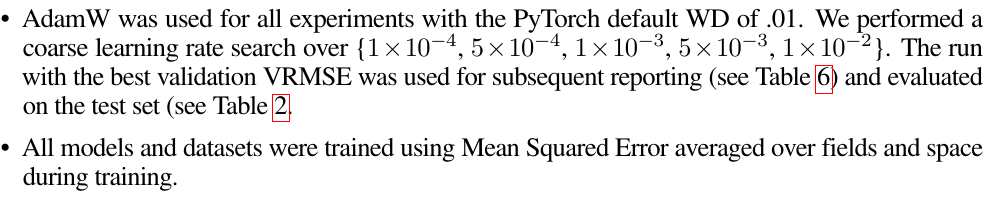

In [19]:
model_dir = "checkpoints/CNextU-net/"

# Create folder if it does not exist
os.makedirs(model_dir, exist_ok=True)

In [42]:
# Training parameters
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
patience = 5  # Early stopping patience

# learning_rate = lr_values[-1]
for learning_rate in lr_values:
    print(f'Model lr = {learning_rate}')
    checkpoint_dir = model_dir+str(learning_rate)

    model = CNextUNet()
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if os.path.exists(checkpoint_dir) and bool(os.listdir(checkpoint_dir)):
        check_numbers = []
        for filename in os.listdir(checkpoint_dir):
            if filename.endswith('pt'):
                check_numbers.append(int(filename[-6:-3]))
        epoch0 = max(check_numbers)
        
        checkpoint = torch.load(checkpoint_dir+f"/epoch_{epoch0:03d}.pt")

        
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f'epoch = {epoch0} loaded')
        epoch0 += 1


        train_losses = np.load(checkpoint_dir+'/train_losses.npy').tolist()
        val_losses = np.load(checkpoint_dir+'/val_losses.npy').tolist() 

        patience_counter = 0
        best_val_loss = min(val_losses)
        print(f'Best previous valitation loss = {best_val_loss}')
        val_i = -1
        if val_losses[val_i] == best_val_loss:
            patience_counter = 0  # Early stopping patience
        else:
            while val_losses[val_i] > best_val_loss:
                patience_counter += 1
                val_i-=1

    else:
        model = model.to(device)
        epoch0=1
        os.makedirs(checkpoint_dir, exist_ok=True)
        if not bool(os.listdir(checkpoint_dir)):
            print('Empty checkpoint directory')
        print(f'Starting at epoch = {epoch0}')
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

    print(f'Patience_counter = {patience_counter}')
    print('')

    for epoch in range(epoch0,101):
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        model.train()
        train_loss = 0.0
        for x, y in (bar := tqdm(train_loader)):
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            pred = model(x)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)

                # Forward pass
                pred = model(x)
                loss = criterion(pred, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss}, Validation loss={val_loss}")
        print(f'Patience counter = {patience_counter}',end='\n\n')

        torch.save({"epoch": epoch,"model_state_dict": model.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"loss": loss,}, checkpoint_dir+f"/epoch_{epoch:03d}.pt")
        np.save(checkpoint_dir+'/train_losses.npy', np.array(train_losses))
        np.save(checkpoint_dir+'/val_losses.npy', np.array(val_losses))

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Model lr = 0.0005
epoch = 38 loaded
Best previous valitation loss = 0.0004499061085831223
Patience_counter = 4



  0%|          | 0/1348 [00:00<?, ?it/s]

  1%|▏         | 20/1348 [00:10<11:57,  1.85it/s]


KeyboardInterrupt: 

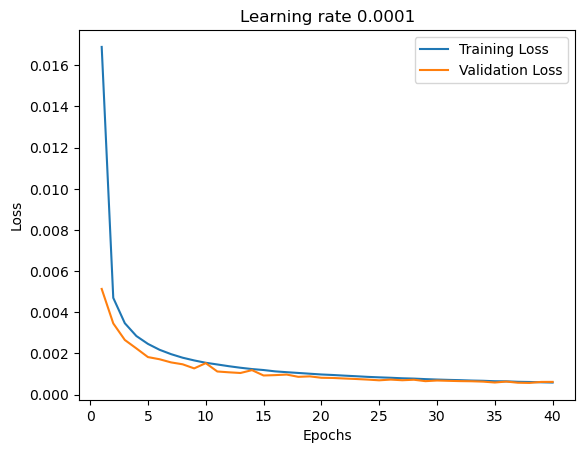

In [25]:
# Plotting the training and validation loss
plt.figure()
plt.title(f'Learning rate {learning_rate}')
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

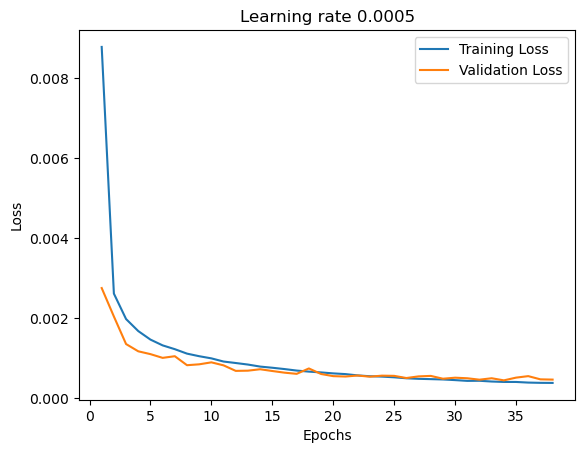

In [43]:
# Plotting the training and validation loss
plt.figure()
plt.title(f'Learning rate {learning_rate}')
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test

In [28]:
test_data = MyDataset("test", 'CNext')
print(len(test_data))
test_loader = torch.utils.data.DataLoader(dataset=test_data, shuffle=True, batch_size=Bsize, num_workers=0)

2002


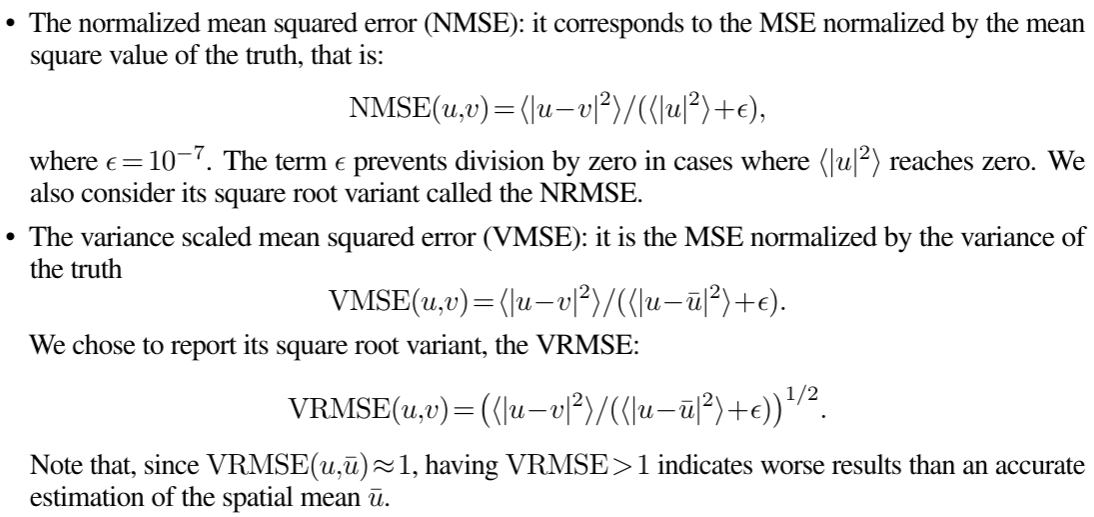

In [40]:
def vrmse(target, pred, eps=1e-7):
    # Mean squared error ⟨|u - v|²⟩
    mse = torch.mean((pred - target)**2)

    # Variance of target: ⟨|u - ū|²⟩
    mean_target = torch.mean(target)
    var = torch.mean((target - mean_target)**2)

    # VRMSE = sqrt(mse / (var + eps))
    return torch.sqrt(mse / (var + eps))


In [41]:
# Test loop
test_vrmse = 0.0
model.eval()
with torch.no_grad():
    for x, y in (bar := tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        batch_vrmse = vrmse(pred, y).item()
        test_vrmse += batch_vrmse

test_vrmse /= len(test_loader)
print(f"\nLearning rate {learning_rate}")
print(f"The test loss in VRMSE is: {test_vrmse:.6f}")


100%|██████████| 201/201 [00:44<00:00,  4.51it/s]


Learning rate 0.0001
The test loss in VRMSE is: 0.052176


In [44]:
# Test loop
test_vrmse = 0.0
model.eval()
with torch.no_grad():
    for x, y in (bar := tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)

        pred = model(x)

        batch_vrmse = vrmse(pred, y).item()
        test_vrmse += batch_vrmse

test_vrmse /= len(test_loader)
print(f"\nLearning rate {learning_rate}")
print(f"The test loss in VRMSE is: {test_vrmse:.6f}")


100%|██████████| 201/201 [00:44<00:00,  4.51it/s]


Learning rate 0.0005
The test loss in VRMSE is: 0.045259


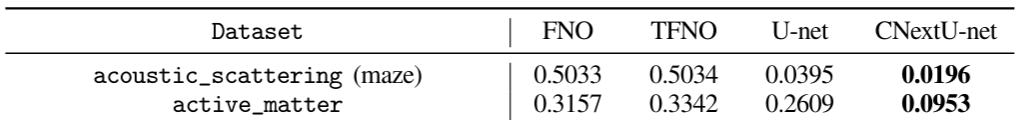
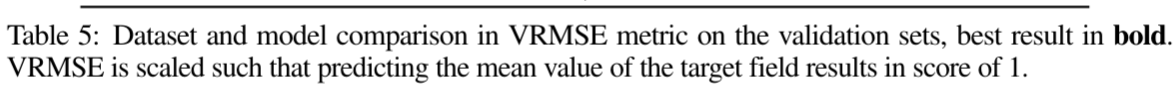

## ConvLSTM

In [20]:
# ConvLSTM Cell

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, padding):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,   # (i,f,o,g gates)
            kernel_size=kernel_size,
            padding=padding
        )

    def forward(self, x, cur_state):
        h_prev, c_prev = cur_state

        combined = torch.cat([x, h_prev], dim=1)
        gates = self.conv(combined)

        i, f, o, g = torch.chunk(gates, 4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, H, W, device):
        return (torch.zeros(batch_size, self.hidden_dim, H, W, device=device),
                torch.zeros(batch_size, self.hidden_dim, H, W, device=device))

# Multi-layer ConvLSTM module

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, num_layers=2):
        super().__init__()

        padding = kernel_size // 2

        layers = []
        dims = [input_dim] + hidden_dim

        for i in range(num_layers):
            layers.append(
                ConvLSTMCell(
                    input_dim=dims[i],
                    hidden_dim=dims[i+1],
                    kernel_size=kernel_size,
                    padding=padding
                )
            )
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        """
        x: (seq_len, batch, channels, H, W)
        """
        seq_len, batch, _, H, W = x.shape
        device = x.device

        h, c = [], []
        for layer in self.layers:
            h.append(None)
            c.append(None)

        output = x

        for layer_idx, layer in enumerate(self.layers):
            h[layer_idx], c[layer_idx] = layer.init_hidden(batch, H, W, device)

            outputs = []
            for t in range(seq_len):
                h[layer_idx], c[layer_idx] = layer(output[t], (h[layer_idx], c[layer_idx]))
                outputs.append(h[layer_idx])

            output = torch.stack(outputs, dim=0)

        return output  # (seq_len, B, hidden_dim[-1], H, W)

# Full ConvLSTM-based next-frame predictor

class ConvLSTMModel(nn.Module):
    def __init__(self, hidden_dims=[64, 64]):
        super().__init__()

        self.convlstm = ConvLSTM(
            input_dim=11,
            hidden_dim=hidden_dims,
            kernel_size=3,
            num_layers=len(hidden_dims)
        )

        # map hidden → output frame
        self.conv_out = nn.Conv2d(hidden_dims[-1], 11, kernel_size=1)

    def forward(self, x):
        """
        x: (B, T=4, H, W, C=11)
        Convert to ConvLSTM format: (T, B, C, H, W)
        """
        # B, T, H, W, C = x.shape
        x = x.permute(1, 0, 4, 2, 3)   # (T, B, C, H, W)

        lstm_out = self.convlstm(x)    # (T, B, hidden_dim, H, W)
        last_hidden = lstm_out[-1]     # last time step

        out = self.conv_out(last_hidden)  # (B, 11, H, W)
        out = out.unsqueeze(1)
        y = y.permute(0, 1, 4, 2, 3)            # (B, 1, 11, H, W)

        return out

In [5]:
Bsize = 10

training_data = MyDataset("train")
print(len(training_data))
train_loader = torch.utils.data.DataLoader(dataset=training_data, shuffle=True, batch_size=Bsize, num_workers=0)

valid_data = MyDataset("valid")
print(len(valid_data))
val_loader = torch.utils.data.DataLoader(dataset=valid_data, shuffle=True, batch_size=Bsize, num_workers=0)

model_dir = "checkpoints/ConvLSTM/"

# Create folder if it does not exist
os.makedirs(model_dir, exist_ok=True)

13475
1848


In [21]:
# Training parameters
lr_values = [5e-4]
patience = 5  # Early stopping patience

# learning_rate = lr_values[-1]
for learning_rate in lr_values:
    print(f'Model lr = {learning_rate}')
    checkpoint_dir = model_dir+str(learning_rate)

    model = ConvLSTMModel(hidden_dims=[64, 64])
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if os.path.exists(checkpoint_dir) and bool(os.listdir(checkpoint_dir)):
        check_numbers = []
        for filename in os.listdir(checkpoint_dir):
            if filename.endswith('pt'):
                check_numbers.append(int(filename[-6:-3]))
        epoch0 = max(check_numbers)
        
        checkpoint = torch.load(checkpoint_dir+f"/epoch_{epoch0:03d}.pt")

        
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f'epoch = {epoch0} loaded')
        epoch0 += 1


        train_losses = np.load(checkpoint_dir+'/train_losses.npy').tolist()
        val_losses = np.load(checkpoint_dir+'/val_losses.npy').tolist() 

        patience_counter = 0
        best_val_loss = min(val_losses)
        print(f'Best previous valitation loss = {best_val_loss}')
        val_i = -1
        if val_losses[val_i] == best_val_loss:
            patience_counter = 0  # Early stopping patience
        else:
            while val_losses[val_i] > best_val_loss:
                patience_counter += 1
                val_i-=1

    else:
        model = model.to(device)
        epoch0=1
        os.makedirs(checkpoint_dir, exist_ok=True)
        if not bool(os.listdir(checkpoint_dir)):
            print('Empty checkpoint directory')
        print(f'Starting at epoch = {epoch0}')
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

    print(f'Patience_counter = {patience_counter}')
    print('')

    for epoch in range(epoch0,101):
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        model.train()
        train_loss = 0.0
        for x, y in (bar := tqdm(train_loader)):     
            x = x.to(device)      
            y = y.to(device)

            # Forward pass
            pred = model(x)
            print(pred.shape)
            print(y.shape)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)

                # Forward pass
                pred = model(x)
                loss = criterion(pred, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss}, Validation loss={val_loss}")
        print(f'Patience counter = {patience_counter}',end='\n\n')

        torch.save({"epoch": epoch,"model_state_dict": model.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"loss": loss,}, checkpoint_dir+f"/epoch_{epoch:03d}.pt")
        np.save(checkpoint_dir+'/train_losses.npy', np.array(train_losses))
        np.save(checkpoint_dir+'/val_losses.npy', np.array(val_losses))

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Model lr = 0.0005
Empty checkpoint directory
Starting at epoch = 1
Patience_counter = 0



  0%|          | 0/1348 [01:16<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 640.00 MiB. GPU 0 has a total capacity of 15.93 GiB of which 0 bytes is free. Of the allocated memory 26.52 GiB is allocated by PyTorch, and 2.85 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Plotting the training and validation loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test

In [ ]:
# Test loop
test_loss = 0.0
model.eval()
with torch.no_grad():
    for x, y in (bar := tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        pred = model(x)
        loss = criterion(pred, y)
        test_loss += loss.item()

test_loss /= len(val_loader)
print(f'The test loss is: {test_loss}')

## U-net with attention

In [ ]:
model_dir = "checkpoints/U-net-Atention/"

# Create folder if it does not exist
os.makedirs(model_dir, exist_ok=True)

In [ ]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ConvNextBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if time_emb_dim is not None else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if self.mlp is not None and time_emb is not None:
            assert time_emb is not None, "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)
    
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = torch.einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = torch.einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


In [ ]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = init_dim if init_dim is not None else dim // 3 * 2
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            raise NotImplementedError()

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )

        else:
            time_dim = None
            self.time_mlp = None
            self.cond_mlp = None
            self.sim_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = out_dim if out_dim is not None else channels
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if self.time_mlp is not None else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [ ]:
# Training parameters
lr_values = [5e-4]
patience = 5  # Early stopping patience

# learning_rate = lr_values[-1]
for learning_rate in lr_values:
    print(f'Model lr = {learning_rate}')
    checkpoint_dir = model_dir+str(learning_rate)

    model = CNextUNet()
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if os.path.exists(checkpoint_dir) and bool(os.listdir(checkpoint_dir)):
        check_numbers = []
        for filename in os.listdir(checkpoint_dir):
            if filename.endswith('pt'):
                check_numbers.append(int(filename[-6:-3]))
        epoch0 = max(check_numbers)
        
        checkpoint = torch.load(checkpoint_dir+f"/epoch_{epoch0:03d}.pt")

        
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f'epoch = {epoch0} loaded')
        epoch0 += 1


        train_losses = np.load(checkpoint_dir+'/train_losses.npy').tolist()
        val_losses = np.load(checkpoint_dir+'/val_losses.npy').tolist() 

        patience_counter = 0
        best_val_loss = min(val_losses)
        print(f'Best previous valitation loss = {best_val_loss}')
        val_i = -1
        if val_losses[val_i] == best_val_loss:
            patience_counter = 0  # Early stopping patience
        else:
            while val_losses[val_i] > best_val_loss:
                patience_counter += 1
                val_i-=1

    else:
        model = model.to(device)
        epoch0=1
        os.makedirs(checkpoint_dir, exist_ok=True)
        if not bool(os.listdir(checkpoint_dir)):
            print('Empty checkpoint directory')
        print(f'Starting at epoch = {epoch0}')
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

    print(f'Patience_counter = {patience_counter}')
    print('')

    for epoch in range(epoch0,101):
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
        model.train()
        train_loss = 0.0
        for x, y in (bar := tqdm(train_loader)):
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            pred = model(x)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)

                # Forward pass
                pred = model(x)
                loss = criterion(pred, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss}, Validation loss={val_loss}")
        print(f'Patience counter = {patience_counter}',end='\n\n')

        torch.save({"epoch": epoch,"model_state_dict": model.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"loss": loss,}, checkpoint_dir+f"/epoch_{epoch:03d}.pt")
        np.save(checkpoint_dir+'/train_losses.npy', np.array(train_losses))
        np.save(checkpoint_dir+'/val_losses.npy', np.array(val_losses))

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

In [ ]:
# Plotting the training and validation loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test

In [ ]:
# Test loop
test_loss = 0.0
model.eval()
with torch.no_grad():
    for x, y in (bar := tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        pred = model(x)
        loss = criterion(pred, y)
        test_loss += loss.item()

test_loss /= len(val_loader)
print(f'The test loss is: {test_loss}')